In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import names
%matplotlib inline

In [7]:
class Infected_Person:
    def __init__(self, env, i, length_of_stay):
        self.env = env        
        self.patient_number = i
        self.length_of_stay = length_of_stay
        self.name = names.get_full_name()
        
        self.infected_process = env.process(self.infected(env))
        
    def infected(self, env):
        # used to be called "patient"
        glob_variables.patient_count += 1
        print("{} (P{}) got infected".format(self.name, self.patient_number))
        
        # request a bed
        bed_req = beds.request()
        print("{} (P{}) is waiting for a bed".format(self.name, self.patient_number))
        
        # start the dying process
        time_till_death = 3
        dying_p = env.process(self.dying(env, time_till_death))
        
        # wait for a bed to show up or to die
        yield bed_req | dying_p
        
        if dying_p.triggered:
            # cancel the bed request and die
            bed_req.cancel()
            # TODO: other dying logic
            print("{} (P{}) died and canceled the bed request".format(self.name, self.patient_number))
        else:
            print("{} (P{}) got a bed".format(self.name, self.patient_number))
            dying_p.interrupt('I got a bed!')
            yield env.timeout(self.length_of_stay)
            print("{} (P{}) recovered".format(self.name, self.patient_number))
            beds.release(bed_req)
            
        
        glob_variables.patient_count-=1
    
    def dying(self, env, time_till_death):
        # try to die but interrupt if there's a bed
        try:
            print("{} (P{}) is starting to die".format(self.name, self.patient_number))
            yield env.timeout(time_till_death)
        except simpy.Interrupt as i:
            # Got the bed! no need to cancel the request
            print("{} (P{}) death process got interrupted".format(self.name, self.patient_number))
            

def new_patient(env,infection_rate,carrying_capacity,length_of_stay):
    i = 0
    while True:
        i+=1
        # patient length of stay is drawn from exponential distribution
        p_length_of_stay = random.expovariate(1/length_of_stay)
        # create a new patient
        p = Infected_Person(env,i,p_length_of_stay)
        # define next patient based on inter arrival time
        lambd = min(7, infection_rate*i*(1-(i/carrying_capacity)))
        next_p = random.expovariate(lambd)
        # trigger event when new patient comes
        yield env.timeout(next_p)

In [3]:
def check(env, delay):
    yield env.timeout(delay)
    while True:
        glob_variables.check_times.append(env.now)
        glob_variables.check_beds.append(beds.count)
        glob_variables.check_untreated.append(glob_variables.patient_count-beds.count)
        yield env.timeout(glob_variables.check_intervals)

In [5]:
class glob_variables:
    patient_count = 0
    infection_rate = 2
    carrying_capacity = 100000
    mean_length_of_stay = 14
    max_bed_capacity = 3
    sim_duration = 50
    check_times = []
    check_beds = []
    check_untreated = []
    check_intervals = 7
    delay = 7
    
    initial_infected = 1
    
    r0 = 2.2
    t_inc = 5.2
    n_susceptible = 100000
    exposed = 0

In [8]:
env = simpy.Environment()
beds = simpy.Resource(env, capacity = glob_variables.max_bed_capacity)
env.process(new_patient(env,glob_variables.infection_rate,glob_variables.carrying_capacity,
                        glob_variables.mean_length_of_stay))
env.process(check(env,glob_variables.delay))
env.run(until=glob_variables.sim_duration)

Kevin Boothe (P1) got infected
Kevin Boothe (P1) is waiting for a bed
Kevin Boothe (P1) is starting to die
Kevin Boothe (P1) got a bed
Kevin Boothe (P1) death process got interrupted
Lauren Zwiebel (P2) got infected
Lauren Zwiebel (P2) is waiting for a bed
Lauren Zwiebel (P2) is starting to die
Lauren Zwiebel (P2) got a bed
Lauren Zwiebel (P2) death process got interrupted
Thomas Arnold (P3) got infected
Thomas Arnold (P3) is waiting for a bed
Thomas Arnold (P3) is starting to die
Thomas Arnold (P3) got a bed
Thomas Arnold (P3) death process got interrupted
Thomas Arnold (P3) recovered
Scott Denner (P4) got infected
Scott Denner (P4) is waiting for a bed
Scott Denner (P4) is starting to die
Scott Denner (P4) got a bed
Scott Denner (P4) death process got interrupted
Alice Sipp (P5) got infected
Alice Sipp (P5) is waiting for a bed
Alice Sipp (P5) is starting to die
Mathew Taylor (P6) got infected
Mathew Taylor (P6) is waiting for a bed
Mathew Taylor (P6) is starting to die
Paul Hixson (

John Sider (P70) got infected
John Sider (P70) is waiting for a bed
John Sider (P70) is starting to die
Ricardo Jimenez (P71) got infected
Ricardo Jimenez (P71) is waiting for a bed
Ricardo Jimenez (P71) is starting to die
Charles Mitchell (P50) died and canceled the bed request
Robert Kiner (P72) got infected
Robert Kiner (P72) is waiting for a bed
Robert Kiner (P72) is starting to die
Stephanie Medina (P51) died and canceled the bed request
James Dotson (P73) got infected
James Dotson (P73) is waiting for a bed
James Dotson (P73) is starting to die
Virginia Skipper (P74) got infected
Virginia Skipper (P74) is waiting for a bed
Virginia Skipper (P74) is starting to die
Patricia Ford (P75) got infected
Patricia Ford (P75) is waiting for a bed
Patricia Ford (P75) is starting to die
Mary Bartlett (P52) died and canceled the bed request
Julio Lenderman (P76) got infected
Julio Lenderman (P76) is waiting for a bed
Julio Lenderman (P76) is starting to die
Lydia Price (P53) died and canceled

Carlos Oatney (P120) got infected
Carlos Oatney (P120) is waiting for a bed
Carlos Oatney (P120) is starting to die
Earnestine Ingalls (P98) died and canceled the bed request
Jermaine Bush (P99) died and canceled the bed request
James Harris (P100) died and canceled the bed request
Elizabeth Holloman (P121) got infected
Elizabeth Holloman (P121) is waiting for a bed
Elizabeth Holloman (P121) is starting to die
Helen Christian (P101) died and canceled the bed request
Rita Cole (P102) died and canceled the bed request
Eleanor Spain (P103) died and canceled the bed request
Clay Patrick (P104) died and canceled the bed request
Andy Bennett (P105) died and canceled the bed request
Joseph Hufft (P122) got infected
Joseph Hufft (P122) is waiting for a bed
Joseph Hufft (P122) is starting to die
Steven Jenkins (P106) died and canceled the bed request
Karen Mcarthur (P123) got infected
Karen Mcarthur (P123) is waiting for a bed
Karen Mcarthur (P123) is starting to die
Rodney Delozier (P107) died

Christopher Rother (P187) got infected
Christopher Rother (P187) is waiting for a bed
Christopher Rother (P187) is starting to die
Sheila Moore (P188) got infected
Sheila Moore (P188) is waiting for a bed
Sheila Moore (P188) is starting to die
Patrick Luna (P189) got infected
Patrick Luna (P189) is waiting for a bed
Patrick Luna (P189) is starting to die
Wanda Duncan (P164) died and canceled the bed request
Eva Gunn (P165) died and canceled the bed request
Susie Davis (P190) got infected
Susie Davis (P190) is waiting for a bed
Susie Davis (P190) is starting to die
Murray Alber (P166) died and canceled the bed request
Elizabeth Amador (P167) died and canceled the bed request
Aida Cissell (P191) got infected
Aida Cissell (P191) is waiting for a bed
Aida Cissell (P191) is starting to die
Effie Timm (P192) got infected
Effie Timm (P192) is waiting for a bed
Effie Timm (P192) is starting to die
Doris Waters (P168) died and canceled the bed request
Daniel Giesen (P169) died and canceled the 

Laverne Zolezzi (P257) got infected
Laverne Zolezzi (P257) is waiting for a bed
Laverne Zolezzi (P257) is starting to die
Larry Seutter (P239) died and canceled the bed request
Thomas Scott (P258) got infected
Thomas Scott (P258) is waiting for a bed
Thomas Scott (P258) is starting to die
Carol Garcia (P259) got infected
Carol Garcia (P259) is waiting for a bed
Carol Garcia (P259) is starting to die
James Williams (P240) died and canceled the bed request
Vicki Haro (P241) died and canceled the bed request
Gary Avenoso (P260) got infected
Gary Avenoso (P260) is waiting for a bed
Gary Avenoso (P260) is starting to die
Hilda Fells (P261) got infected
Hilda Fells (P261) is waiting for a bed
Hilda Fells (P261) is starting to die
Matthew Dean (P262) got infected
Matthew Dean (P262) is waiting for a bed
Matthew Dean (P262) is starting to die
Maureen Ray (P263) got infected
Maureen Ray (P263) is waiting for a bed
Maureen Ray (P263) is starting to die
Francisco Benck (P264) got infected
Francis

Mary Vullo (P325) got infected
Mary Vullo (P325) is waiting for a bed
Mary Vullo (P325) is starting to die
Ronald Jacobsen (P326) got infected
Ronald Jacobsen (P326) is waiting for a bed
Ronald Jacobsen (P326) is starting to die
Debra Nelson (P305) died and canceled the bed request
Helen Taylor (P327) got infected
Helen Taylor (P327) is waiting for a bed
Helen Taylor (P327) is starting to die
Letitia Johnson (P306) died and canceled the bed request
Donald Parks (P307) died and canceled the bed request
Silvia Benjamin (P308) died and canceled the bed request
Kevin Cegielski (P328) got infected
Kevin Cegielski (P328) is waiting for a bed
Kevin Cegielski (P328) is starting to die
Henry Lancaster (P329) got infected
Henry Lancaster (P329) is waiting for a bed
Henry Lancaster (P329) is starting to die
Dennis Winfield (P330) got infected
Dennis Winfield (P330) is waiting for a bed
Dennis Winfield (P330) is starting to die
Margarito Trier (P331) got infected
Margarito Trier (P331) is waiting 

In [119]:
Hospital_Ut = pd.DataFrame()
Hospital_Ut["Days Since Outbreak"] = glob_variables.check_times
Hospital_Ut["Bed Count"] = glob_variables.check_beds
Hospital_Ut["Untreated Patients"] = glob_variables.check_untreated

In [123]:
pd.set_option('display.max_rows',None)
Hospital_Ut

,Days Since Outbreak,Bed Count,Untreated Patients
0,7,40,0
1,14,73,0
2,21,95,0
3,28,99,0
4,35,89,0
5,42,84,0
6,49,80,0
7,56,100,2
8,63,100,1
9,70,93,0


In [93]:
def plot_graph(x,y):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(Hospital_Ut[x],Hospital_Ut[y])
    ax.set_xlabel(str(x))
    ax.set_ylabel(str(y))
    plt.xlim(0,glob_variables.sim_duration)
    plt.title("{} vs. {}".format(y,x),fontweight = "bold")

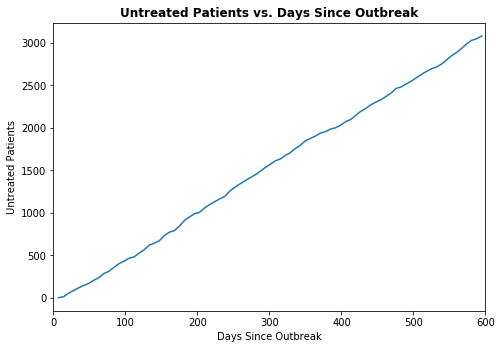

In [94]:
plot_graph("Days Since Outbreak","Untreated Patients")